In [ ]:
# Importations
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

import seaborn as sns
from typing import Tuple


In [2]:
# Fonction d'affichage des graphes de loss/accuracy
class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Val')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Val')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [2]:
# Fonction de création d'une image 'imparfaite' via une ancienne image - style 2

def create_imperfect_image(image, image_size=(56, 56), seed=42):
    random.seed(seed)
    new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

    max_offset = image_size[0] - image.shape[0]
    random_x = random.randint(0, max_offset)
    random_y = random.randint(0, max_offset)

    new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
    return new_image

Le but est d'améliorer la robustesse du modèle de reconnaissance de chiffres manuscrits face aux variations de position, d'orientation et de taille des chiffres.

Créons donc un dataset augmenté contenant des variations réalistes de chiffres manuscrits pour entraîner un modèle plus performant et généralisable.

L'augmentation des données avec des transformations réalistes permettra d'améliorer la performance du modèle.

Méthodes:
- generation_propre: Génère de nouvelles images en appliquant des transformations géométriques aléatoires comme la rotation, le décalage, le zoom. (aussi nommé style 1)
- generation_imparfaite: Simule des imperfections en plaçant les chiffres à des positions aléatoires sur un fond plus grand. Cela vise à rendre le modèle plus robuste aux variations de position et de taille. (aussi nommé style 2)

Ces deux méthodes d'augmentation visent à couvrir un large spectre de variations réalistes que le modèle pourrait rencontrer en pratique.

In [3]:
# Fonction de création de nouvelles images via d'anciennes - style 1
def generation_propre(images: np.ndarray, labels: np.ndarray, nb=10000, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=(1.1, 1.9),
    )

    new_images_generator = datagen.flow(images, batch_size=1, shuffle=False, seed=seed)

    X_new = images.tolist()
    y_new = labels.tolist()
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axs = axs.flatten()
    current_seed = seed
    for i in range(nb):

        new_images_generator = datagen.flow(images[i:i+1], batch_size=1, shuffle=False, seed=current_seed)
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(labels[i].tolist())
        current_seed += 1
        if i < 6:
          axs[i].imshow(img, cmap="grey")
          axs[i].axis("off")
    plt.show()
    return np.array(X_new), np.array(y_new)


Fonction de création de nb images modifiées par create_imperfect_image sur les images (style 2)

In [4]:
# Fonction de création de nouvelles images via d'anciennes - style 2

def generation_imparfaite(images: np.ndarray, labels: np.ndarray, nb=10000, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    new_images = images.tolist()
    new_images_label = labels.tolist()

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axs = axs.flatten()

    for i in range(nb):
        imperfect_image = create_imperfect_image(images[i], seed=i+seed)

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(labels[i].tolist())

        if i < 6:

          axs[i].imshow(imperfect_image, cmap="grey")
          axs[i].axis("off")

    plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

Le jeu de données MNIST est chargé. Il contient 60 000 images pour l'entraînement et 10 000 pour les tests.

Les images sont normalisées en ajustant les valeurs de pixels entre 0 et 1.

Les couleurs sont inversées pour avoir des chiffres noirs sur fond blanc.

120 000 nouvelles images sont créées pour l'entraînement :
- _generation_propre_ : Rotation, décalage et zoom aléatoires des chiffres.
- _generation_imparfaite_ : Placement des chiffres à des positions aléatoires sur un fond plus grand.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


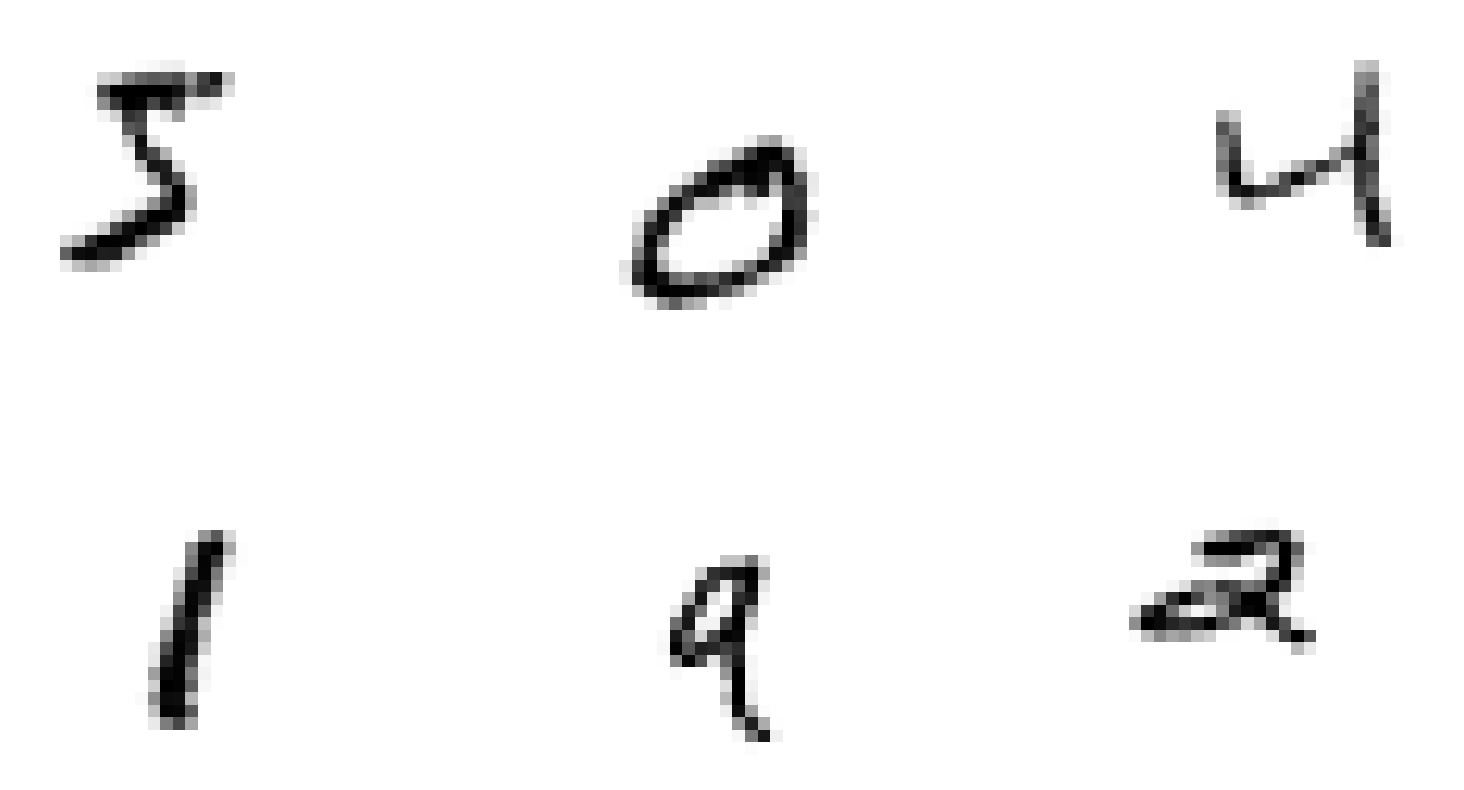

In [5]:
# Chargement et traitement des données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

# Génération de nouvelles données imparfaites
x_train, y_train = generation_propre(x_train, y_train, 60000) #  style 1

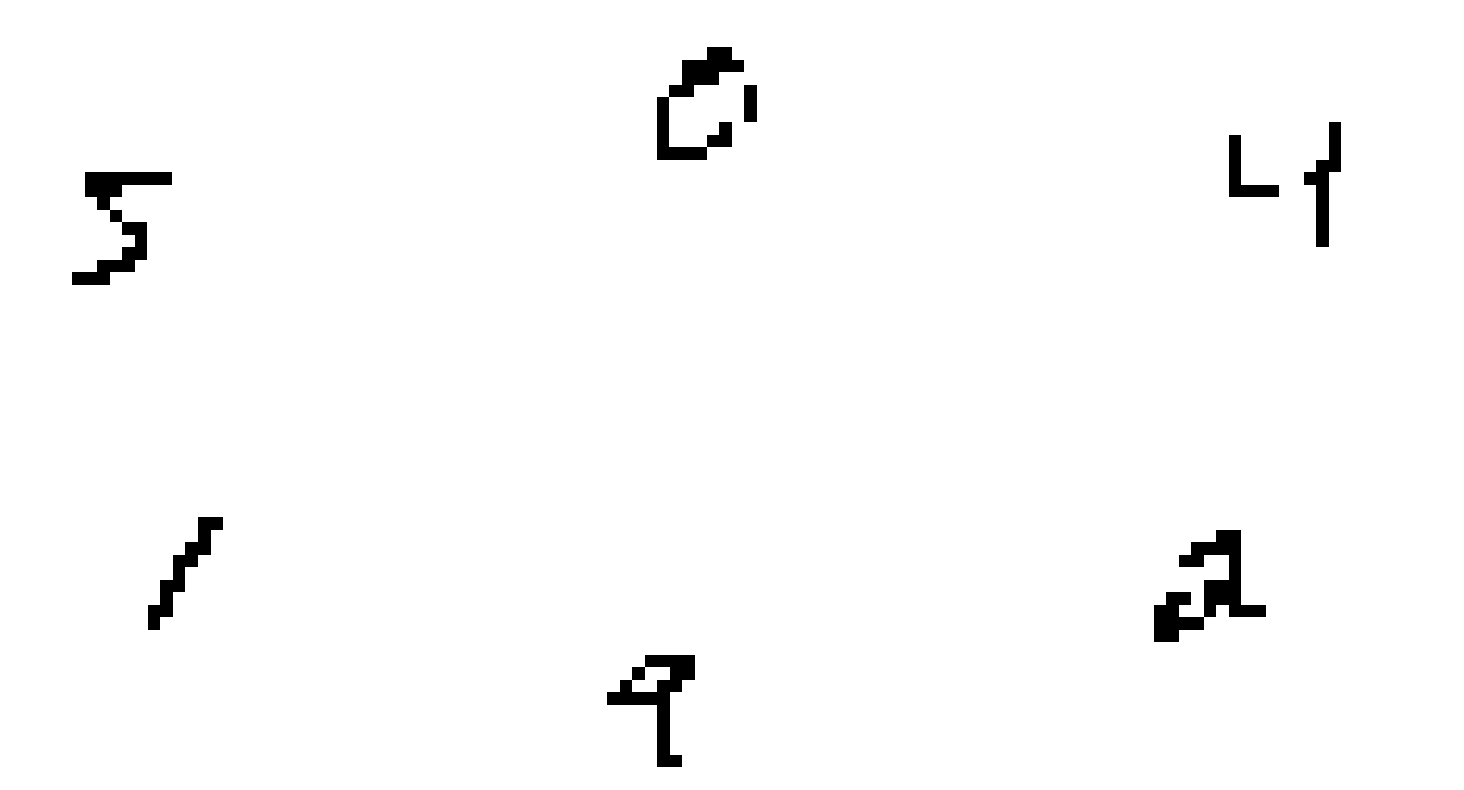

In [6]:
# Génération de nouvelles données imparfaites
x_train, y_train = generation_imparfaite(x_train, y_train, 60000) #  style 2

- Affichage des 6 premiers éléments du jeu d'entrainement de base

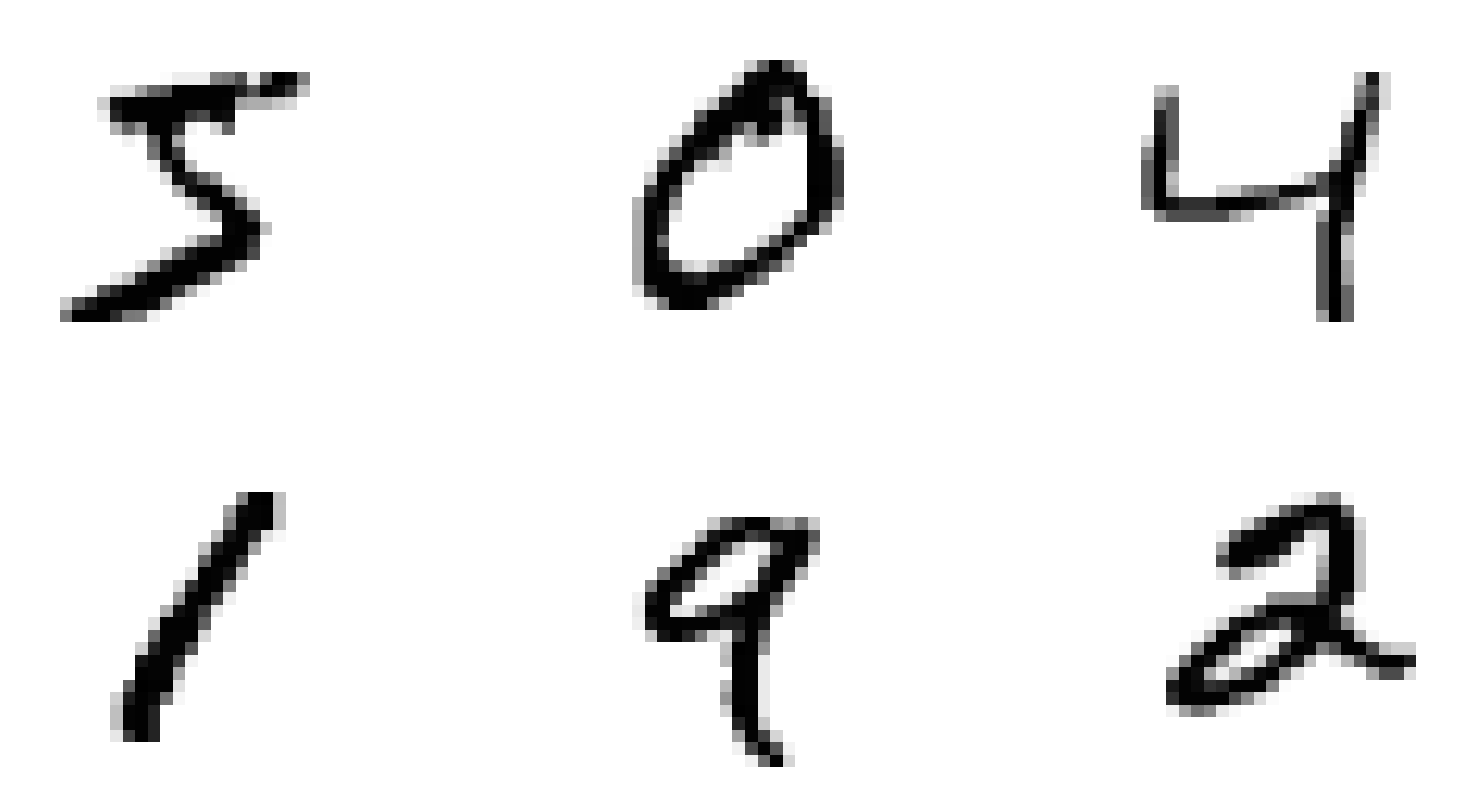

In [ ]:
# Apercu dataset de base
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(x_train[i], cmap="grey")
    axs[i].axis("off")
plt.show()

- Mélange du jeu d'entrainement

In [13]:

# Mélange (pour validation_split)
np.random.seed(42)
indice = np.random.permutation(len(x_train))
x_train = x_train[indice]
y_train = y_train[indice]

**Optimisation bayésienne (Keras Tuner)**

Fonctionnement : Utilise un modèle probabiliste pour prédire la performance du modèle en fonction des hyperparamètres et choisit les plus prometteurs à évaluer. Itère ce processus pour trouver les meilleurs hyperparamètres.

Avantages : Plus efficace que la recherche aléatoire, trouve de meilleures solutions et estime l'incertitude des performances.

Inconvénients : Plus coûteuse en calcul et sensible au choix de l'a priori.

In [ ]:
# Optimisation Bayésienne

def build_model(hp):
    model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Flatten(),

      Dense(hp.Choice('units_1', [512, 1024, 2048]), activation='relu'),
      Dropout(0.25),
      BatchNormalization(),
      Dense(hp.Choice('units_2', [512, 1024, 2048]), activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
    ])
    optimizer = Adam(0.001, weight_decay=0.0005)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
)

tuner.search(x_train, y_train, epochs=5, validation_split=0.2, batch_size=128)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleures valeurs trouvées :", best_hyperparameters.values)


**Optimisation par recherche aléatoire**

Fonctionnement : Évalue le modèle avec des hyperparamètres choisis aléatoirement dans un espace de recherche et sélectionne le meilleur.

Avantages : Simple à mettre en œuvre, étonnamment efficace et facilement parallélisable.

Inconvénients : Moins efficace que l'optimisation bayésienne et peut ne pas trouver la meilleure solution.

In [ ]:
# Optimisation random search

def build_model(rate_1, rate_2, rate_3, units_1, units_2, activation):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Reshape((-1, 128)),

        Bidirectional(GRU(units_1, activation=activation, return_sequences=True)),
        Dropout(rate_2),

        Bidirectional(GRU(units_2, activation=activation)),
        Dropout(rate_3),

        Dense(10, activation="softmax")
    ])

    optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

param_distributions = {
    'rate_1': [0.2, 0.3, 0.4],
    'rate_2': [0.2, 0.3, 0.4, 0.5],
    'rate_3': [0.2, 0.3, 0.4, 0.5],
    'units_1': [64, 128, 256],
    'units_2': [64, 128, 256],
    'activation': ['tanh', 'relu']
}

best_params = {'acc' : 0}
for i in range(20):
  params = []
  for i in range(len(param_distributions)):
    params.append(random.choice(param_distributions[list(param_distributions.keys())[i]]))
  model = build_model(*params)
  historique = model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=128, verbose=0)

  if historique.history['val_accuracy'][-1] > best_params['acc']:
    best_params['acc'] = historique.history['val_accuracy'][-1]
    best_params['params'] = params

print("Meilleurs paramètres trouvés :", best_params)


Le modèle est un réseau neuronal convolutif (CNN) conçu pour la classification d'images. Il prend en entrée une image en niveaux de gris de taille 28x28 pixels, représentée par une matrice (28, 28, 1).

Le modèle utilise 3 couches de double convolution. Chaque couche de convolution applique un ensemble de filtres à l'image d'entrée pour extraire des caractéristiques. L'augmentation progressive du nombre de neurones dans les couches de convolution permet au modèle d'apprendre des caractéristiques de plus en plus complexes.
- La double convolution permet d'affiner la détection de caractéristiques.
- Max Pooling : Réduit la dimensionnalité des données en sélectionnant la valeur maximale dans une fenêtre donnée.

Batch Normalization: Normalise les activations des couches précédentes, ce qui accélère la convergence du modèle pendant l'entraînement.

Dropout: Désactive aléatoirement des neurones pendant l'entraînement, ce qui force le modèle à apprendre des représentations plus robustes et à éviter le surapprentissage.

Couches entièrement connectées: Deux couches entièrement connectées avec 512 neurones chacune. Ces couches combinent les caractéristiques extraites par les couches convolutives pour effectuer la classification finale.

Sortie softmax: La couche de sortie utilise une fonction softmax pour produire une distribution de probabilité sur les 10 classes possibles (chiffres de 0 à 9).

Optimisation : Le modèle est entraîné en utilisant l'optimiseur AdamW

In [34]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.4),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

**Validation croisée**

L'entraînement du modèle est effectué en utilisant une validation croisée K-Fold avec 5 folds. Cela signifie que le jeu de données d'entraînement est divisé en 5 parties, et le modèle est entraîné 5 fois, en utilisant chaque partie comme ensemble de validation à tour de rôle. Cela permet d'obtenir une estimation plus robuste de la performance du modèle et de réduire le risque de surapprentissage.

**Callbacks : ReduceLROnPlateau**

Le callback ReduceLROnPlateau est utilisé pour réduire dynamiquement le taux d'apprentissage pendant l'entraînement lorsque la performance du modèle sur un ensemble de validation cesse de s'améliorer.

**Évaluation**

La performance du modèle est évaluée en utilisant l'accuracy et la perte. L'accuracy mesure la proportion de prédictions correctes, tandis que la perte quantifie l'erreur du modèle. L'évolution de ces métriques au cours de l'entraînement est affichée pour surveiller la convergence du modèle et détecter un éventuel surapprentissage.

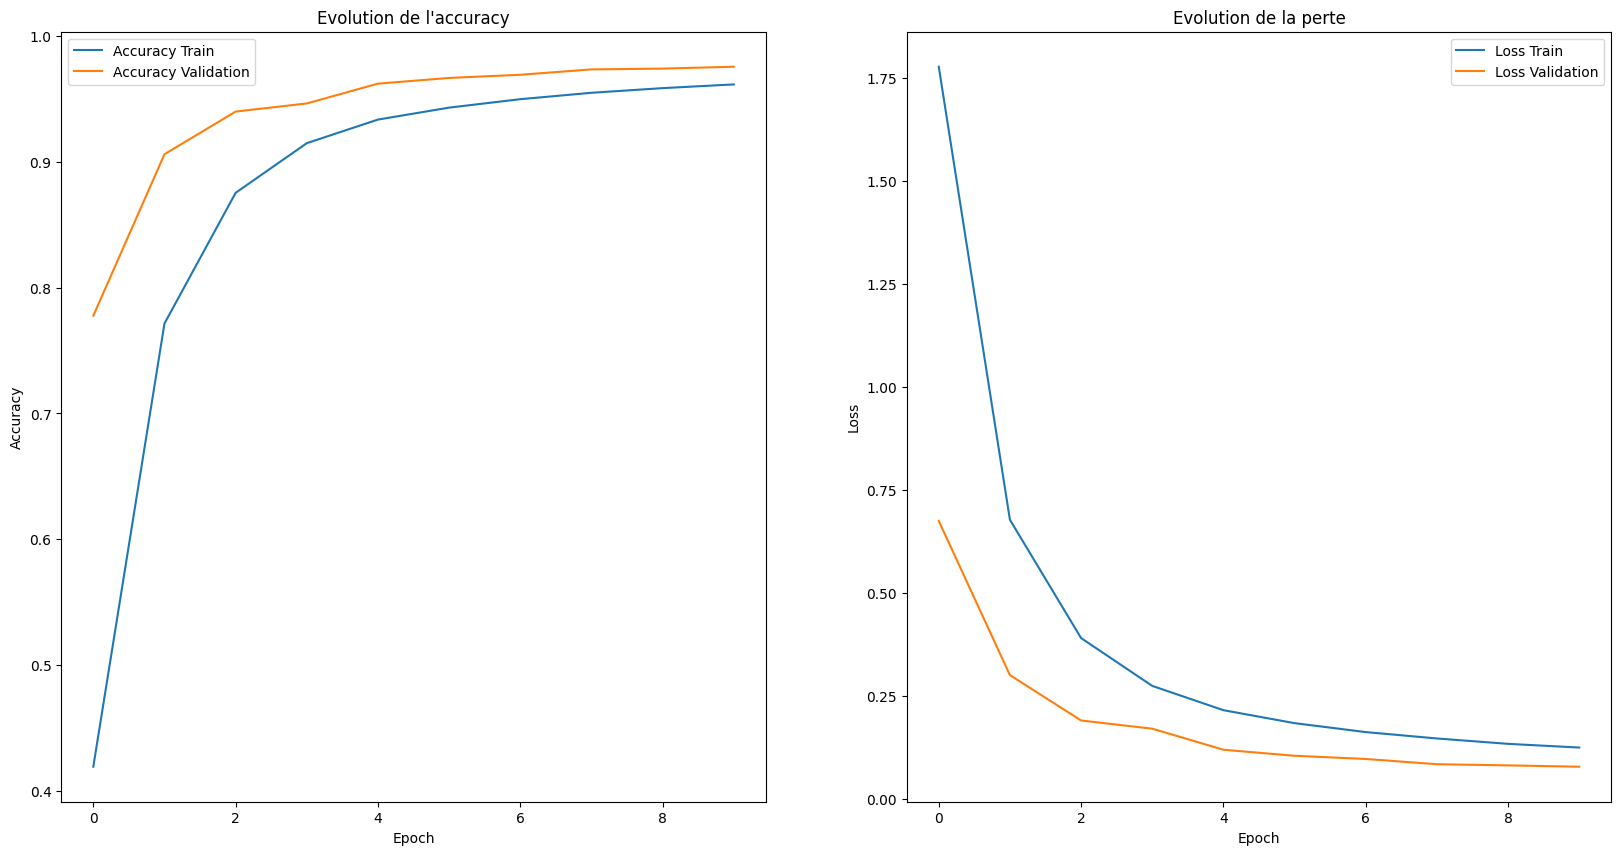

Acccuracy :  0.9614916682243347
Loss :  0.12502431720495225
Accuracy Validation :  0.9755555629730225
Loss Validation :  0.07853316217660904


In [35]:
# Entrainement - Cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=0,
    min_lr=1e-6,
    verbose=1
)

accuracies = []
loss = []
val_accuracies = []
val_loss = []
i = 1

for train_index, val_index in kf.split(x_train, y_train):
    X, x_val = x_train[train_index], x_train[val_index]
    y, y_val = y_train[train_index], y_train[val_index]

    print(f"Fold {i}")
    i += 1

    model = build_model()
    historique = model.fit(X, y, epochs=10, validation_data=(x_val, y_val), batch_size=128, callbacks=[reduce_lr])

    accuracies.append(historique.history["accuracy"])
    val_accuracies.append(historique.history["val_accuracy"])
    loss.append(historique.history["loss"])
    val_loss.append(historique.history["val_loss"])

    clear_output(wait=True)

accuracies = np.array(accuracies)
loss = np.array(loss)
val_accuracies = np.array(val_accuracies)
val_loss = np.array(val_loss)

accuracies = np.mean(accuracies, axis=0)
loss = np.mean(loss, axis=0)
val_accuracies = np.mean(val_accuracies, axis=0)
val_loss = np.mean(val_loss, axis=0)

# Affichage accuracy - loss
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(accuracies, label='Accuracy Train')
axs[0].plot(val_accuracies, label='Accuracy Validation')
axs[0].set_title(f"Evolution de l'accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(loss, label='Loss Train')
axs[1].plot(val_loss, label='Loss Validation')
axs[1].set_title(f"Evolution de la perte")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.show()

print('Acccuracy : ', accuracies[-1])
print('Loss : ', loss[-1])
print('Accuracy Validation : ', val_accuracies[-1])
print('Loss Validation : ', val_loss[-1])

In [46]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

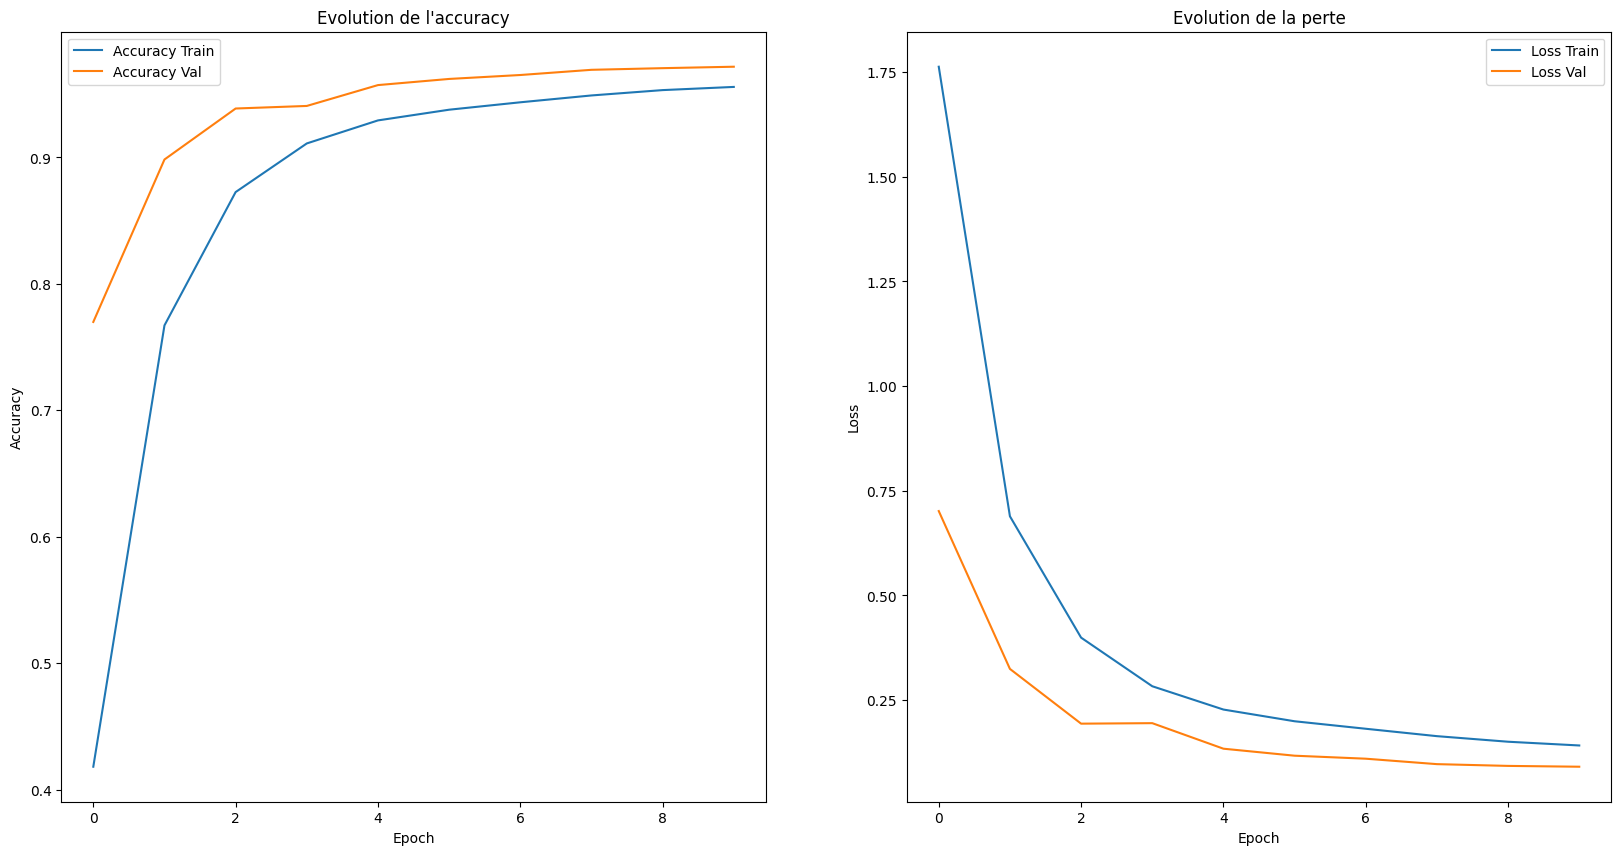

In [36]:
Graphes.accuracy_loss_graphe(historique)

Maintenant, voici les résultats sur les tests de base (10 000 images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       1.00      1.00      1.00      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



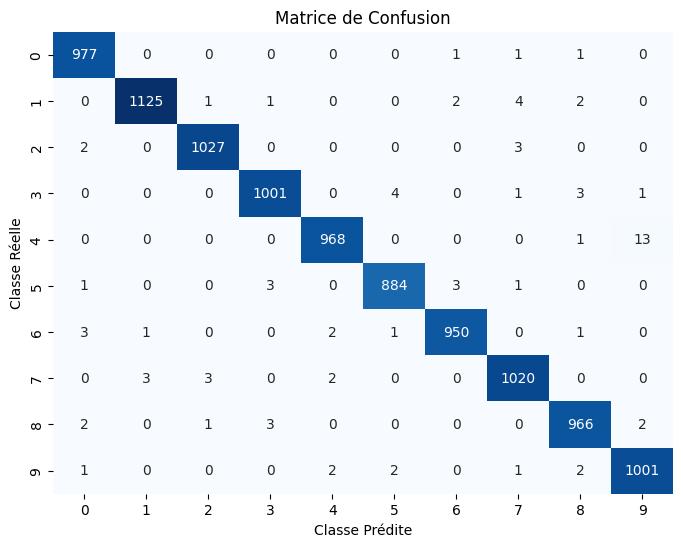

In [37]:
# Stats et matrice de confusion

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


Modification de 10 000 images de test par generation_propre (style 1)
On ne garde que les images générées

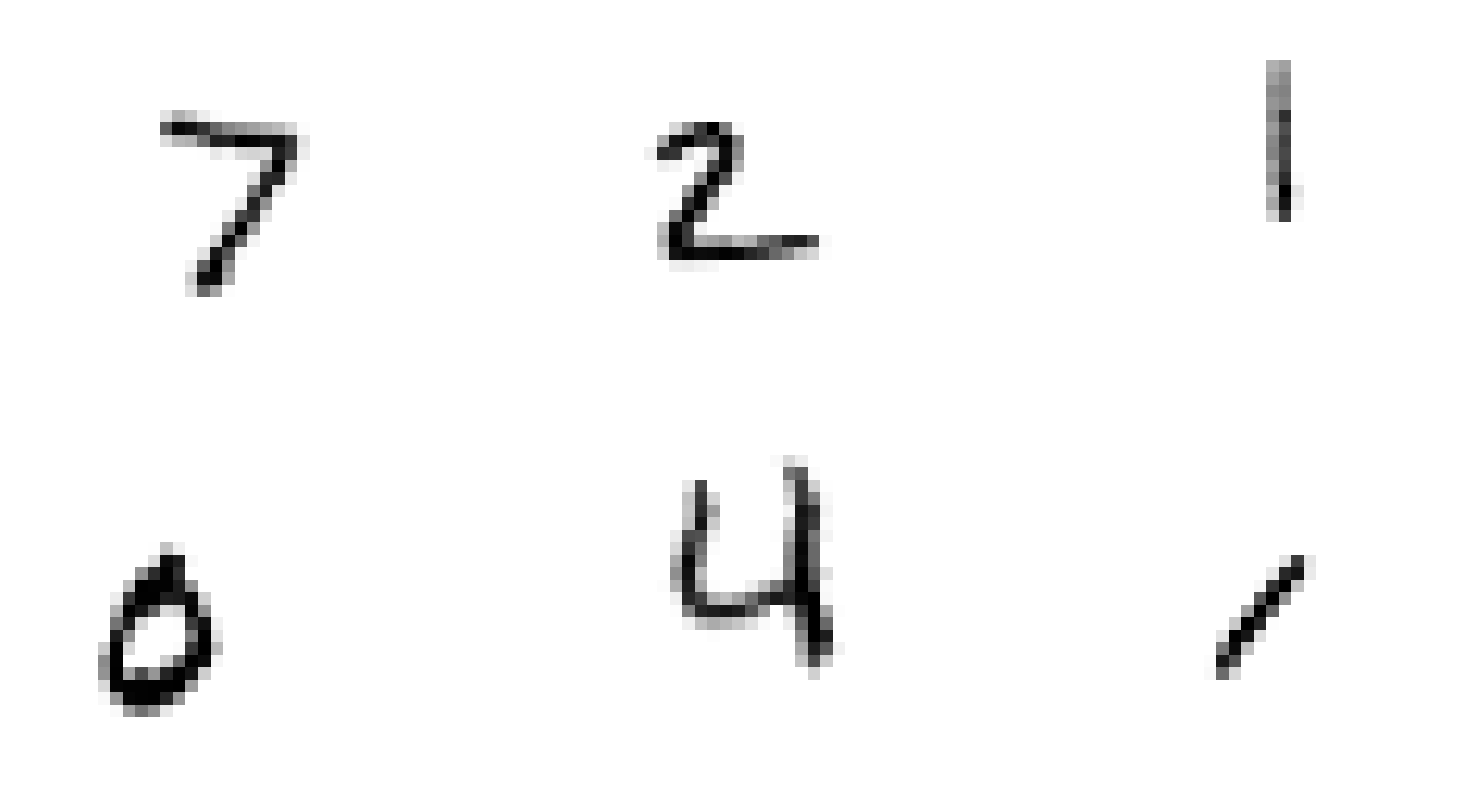

In [38]:
# generation_propre - style 1

new_images_propre, new_images_propre_label = generation_propre(x_test, y_test, nb=10000, seed=2)
new_images_propre, new_images_propre_label = new_images_propre[10000:], new_images_propre_label[10000:]

Et voici les résultats sur les 10 000 images de tests après avoir été modifiées par _generation_propre_ (style 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.99      0.97      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



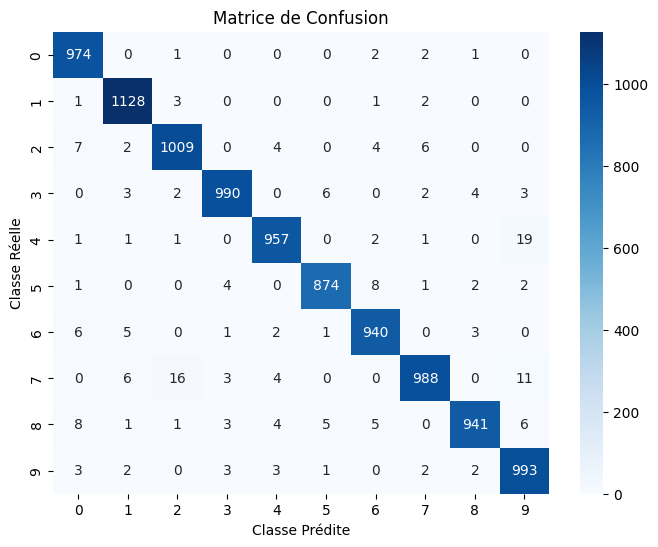

In [39]:
# Stats et matrice de confusion sur données générées (generation_propre)


# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images_propre), axis=1)

print(classification_report(new_images_propre_label, new_pred))

confusion = confusion_matrix(new_images_propre_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



Modification de 10 000 images de test par generation_imparfaite (style 2)
On ne garde que les images générées

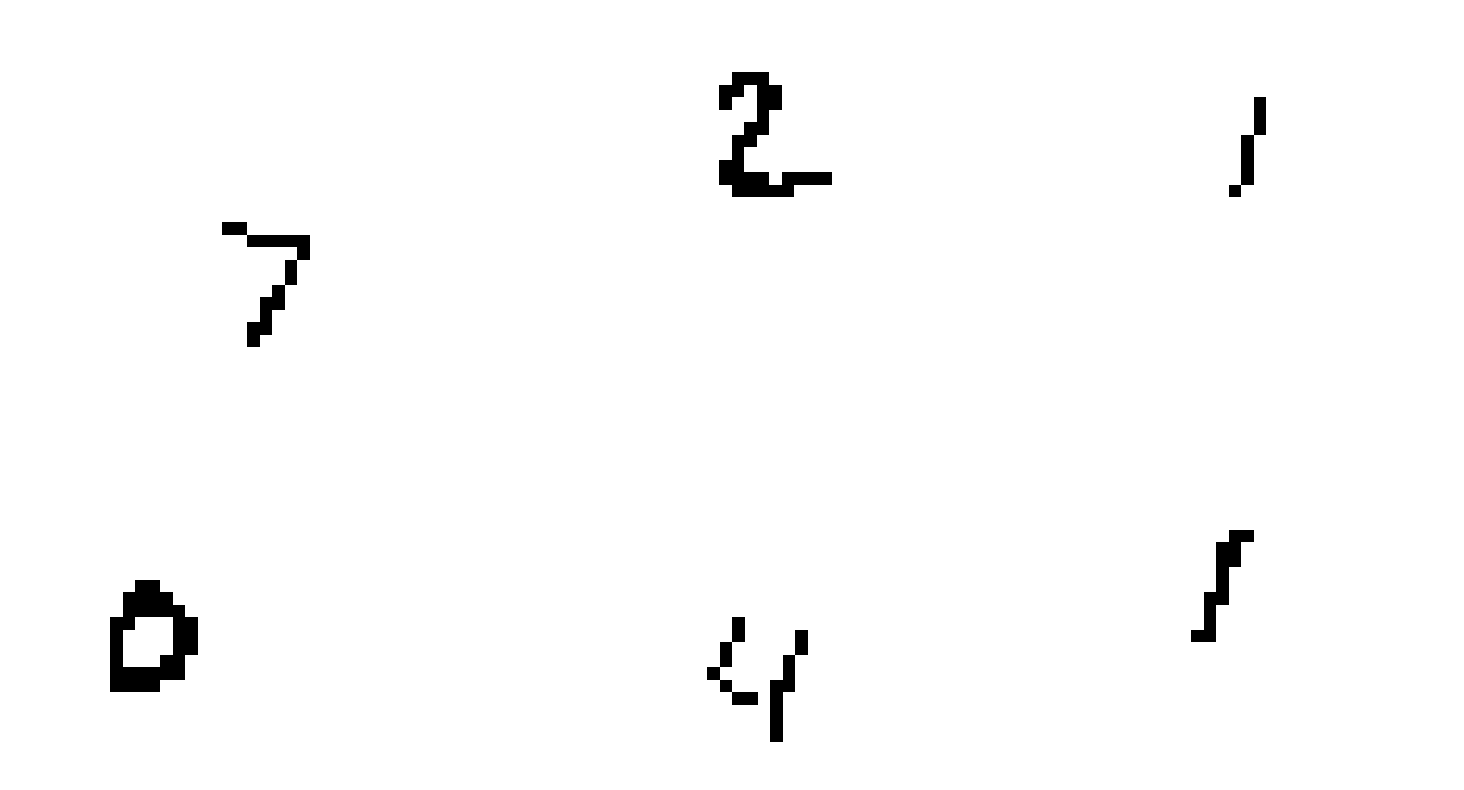

In [40]:
# generation_imparfaite - style 2
new_images, new_images_label = generation_imparfaite(x_test, y_test, seed=2)
new_images, new_images_label = new_images[10000:], new_images_label[10000:]

3e tests, toujours les 10 000 images du jeu de tests mais cette fois, en étant modifiées pas generation_imparfaite (style 2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.93      0.95       982
           5       0.96      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.95      0.95       974
           9       0.91      0.95      0.92      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



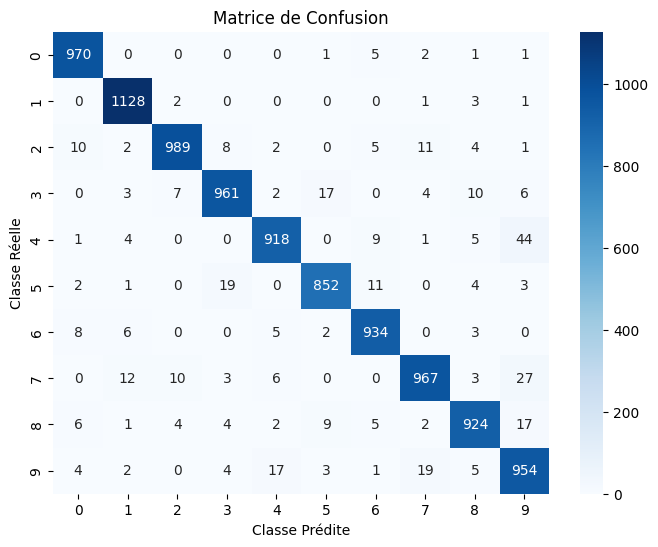

In [41]:
# Stats et matrice de confusion sur données générées (generation_2)

# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



Concaténation des 30 000 images testées précédement

In [42]:
# Combinaison de toutes les données de tests

x_test_global = np.concatenate((x_test, new_images, new_images_propre))
y_test_global = np.concatenate((y_test, new_images_label, new_images_propre_label))

Enfin, la moyenne des 3 tests précédent (30 000 images au total)

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2940
           1       0.98      0.99      0.99      3405
           2       0.98      0.98      0.98      3096
           3       0.98      0.97      0.98      3030
           4       0.98      0.97      0.97      2946
           5       0.98      0.98      0.98      2676
           6       0.98      0.98      0.98      2874
           7       0.98      0.96      0.97      3084
           8       0.98      0.97      0.97      2922
           9       0.95      0.97      0.96      3027

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



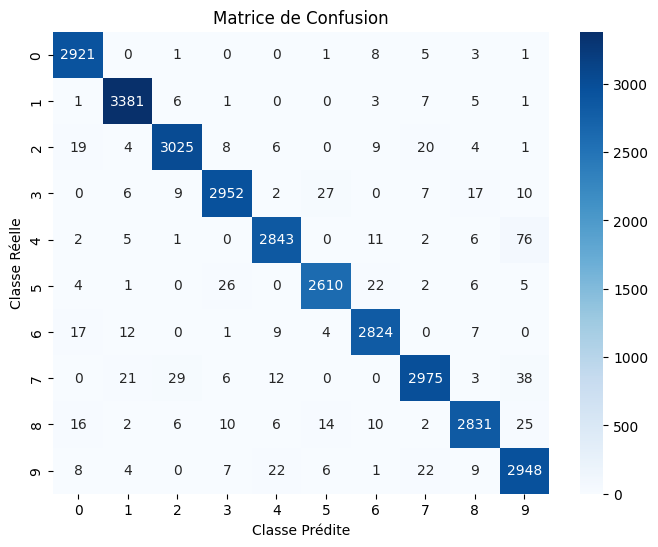

In [43]:
# Stats et matrice de confusion sur TOUTES données

new_pred = np.argmax(model.predict(x_test_global), axis=1)

print(classification_report(y_test_global, new_pred))

confusion = confusion_matrix(y_test_global, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_final.png", format="png")
plt.show()

